<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/m4s_traction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A tutorial
- Variational problem setup (static)
- Elastic problem


**Goal:**

Denoting by $u$ the displacement field (vector valued) and by $\alpha$ the scalar damage field we consider the energy functional

$$
		\mathcal{E}_{\ell}(u, \alpha)=
		\dfrac{1}{2}\int_{\Omega} a({\alpha})
		A_0\,\epsilon(u)\cdot\epsilon(u)\,dx
		+
         \,
		\dfrac{G_c}{c_w} \int_{\Omega}\left(
		\dfrac{w(\alpha)}{\ell}+
		{\ell}\,\nabla {\alpha}\cdot\nabla{\alpha}\right)dx
$$

where $\epsilon(u)$ is the strain tensor, $\sigma_0(u)=A_0\,\epsilon(u) = 2{\mu} \epsilon(u) + {\lambda}tr(\epsilon(u))I_2$ the stress of the undamaged material, $a({\alpha})$  the stiffness modulation function though the damage field, $w(\alpha)$ the energy dissipation in an homogeouns process and $\ell$ the internal length.

In the following we will solve, at each time step $t_i$ the minimization problem 

$$
\min\mathcal{E}_{\ell}(u, \alpha),\quad u\in\mathcal{C}_i, \alpha\in \mathcal{D}_i
$$

where $\mathcal{C}_i$ is the space of kinematically admissible displacement at 
time $t_i$ and $\mathcal{D}_i$ the admissible damage fields, that should respect the irreversibility conditions 
$\alpha\geq\alpha_{i-1}$. 




In [55]:
import site
import sys


try : 
    from google.colab import files
except:
    pass
    
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y fenics    
    site.addsitedir('/usr/lib/petsc/lib/python3/dist-packages')  # Always appends to end

    from fenics import *; from mshr import *
    from ufl import replace

!fenics-version

2019.2.0.dev0


In [56]:
import matplotlib.pyplot as plt;
import numpy as np;
from IPython.display import clear_output, display, update_display; import time; 
# import dolfin.common.plotting as fenicsplot 
import time
%matplotlib inline
plt.rcParams['image.cmap'] = 'viridis'


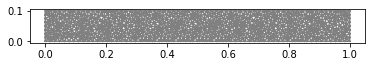

In [42]:
L = 1.; H = .1
cell_size = 0.02
nel = int(L/cell_size)

geom= Rectangle(Point(0., 0.), Point(L, H))
mesh = generate_mesh(geom, nel)
plot(mesh)

In [43]:
left = CompiledSubDomain('near(x[0], 0, 1e-4)')
right = CompiledSubDomain('near(x[0], {}, 1e-4)'.format(L))

boundaries = MeshFunction('size_t', mesh, 1)
boundaries.set_all(0)

left.mark(boundaries, 1) # mark left as 1
right.mark(boundaries,2) # mark right as 2
ds = Measure('ds', subdomain_data=boundaries) # surface measures ds(1), ds(2)




In [44]:
# Constitutive functions

E, nu = Constant(1.), Constant(.3)
Gc = Constant(1.)
ell = Constant(0.1)

ndim = mesh.topology().dim()

# w(a), 

def w(alpha):
  return alpha

def a(alpha):
  return (1-alpha)**2

def eps(u):
  return sym(grad(u))

def sigma0(u):
  mu = E/(2.*(1.+nu))
  lmbda = E*nu/(1-nu**2.)
  return 2*mu*eps(u) + lmbda*tr(eps(u))*Identity(ndim)

def sigma(alpha, u):
  return a(alpha)*sigma0(u)

In [45]:
# Function spaces

V_u = VectorFunctionSpace(mesh, 'P', 1)
V_alpha = FunctionSpace(mesh, 'P', 1)

u = Function(V_u)
du = TrialFunction(V_u)
v = TestFunction(V_u)
alpha = Function(V_alpha)
beta = TestFunction(V_alpha)
dalpha = TrialFunction(V_alpha)


In [46]:
cw = 8/3

elastic_energy = 0.5*inner(sigma(alpha, u), eps(u))*dx
dissipated_energy = Gc/cw * (w(alpha)/ell + ell* inner(grad(alpha), grad(alpha)))*dx

total_energy = elastic_energy + dissipated_energy 

E_u = derivative(total_energy, u, v)

E_du = replace(E_u, {u: du})

E_alpha = derivative(total_energy, alpha, beta)
E_alpha_alpha = derivative(E_alpha,alpha, dalpha)



In [47]:
# Boundary conditions
u_R = Expression(('t', 0), t=0., degree=0)

bcu_0 = DirichletBC(V_u, u_R, boundaries, 2)
bcu_1 = DirichletBC(V_u, Constant((0., 0.)), boundaries, 1)
bc_u = [bcu_0, bcu_1]


bca_0 = DirichletBC(V_alpha, Constant(0.), boundaries, 2)
bca_1 = DirichletBC(V_alpha, Constant(0.), boundaries, 1)

bc_a = [bca_0, bca_1]


In [54]:
# Solve displacement problem


problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bc_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "umfpack"})

In [51]:
u_R.t = .1
solver_u.solve()

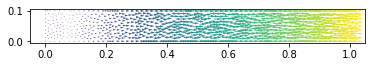

In [53]:
plot(u)